# Sweet Lift Taxi Company

### Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders.  Our goal is to use current taxi orders to better predict future orders.

## Preparation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = 'https://code.s3.yandex.net/datasets/taxi.csv'
df = pd.read_csv(url)

In [3]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
num_duplicates = df.duplicated().sum()
# print number of duplicate rows 
print(f"duplicate rows: {num_duplicates}")

duplicate rows: 0


In [5]:
# convert to datetime format 
df['datetime'] = pd.to_datetime(df['datetime'])
# Set 'datetime' as the index
df.set_index('datetime', inplace=True)

## Analysis

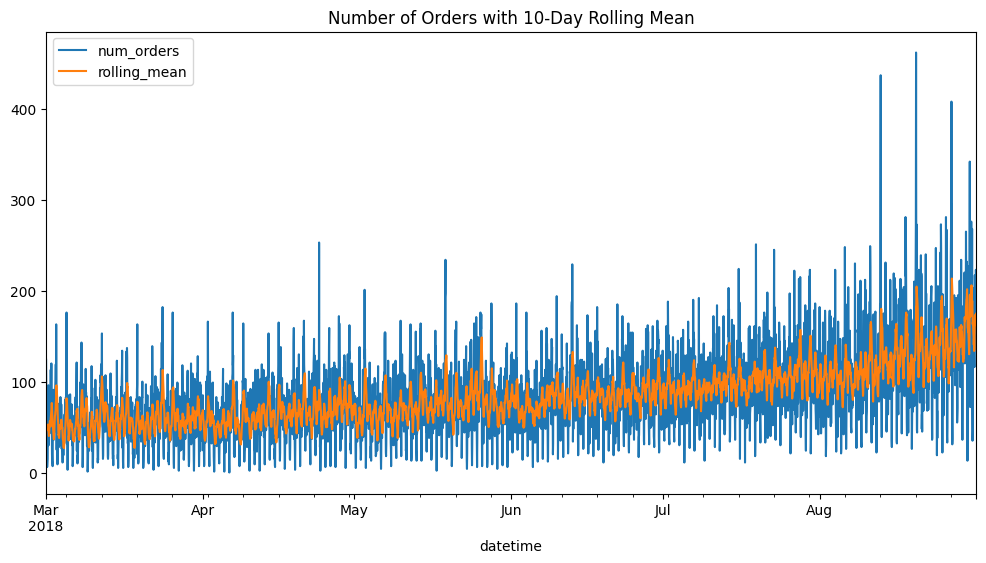

In [6]:
# rolling mean
df = df.resample('1H').sum()
df['rolling_mean'] = df['num_orders'].rolling(10).mean()

# plot
df[['num_orders', 'rolling_mean']].plot(figsize=(12, 6), title='Number of Orders with 10-Day Rolling Mean')
plt.show()

### There appears to be a clear pattern and trend. In the short term, the number of taxi orders rises and falls. Over the year 2018, we start to see a gradual rise in orders.

ADF Statistic: -3.068924289027954
p-value: 0.028940051402613028


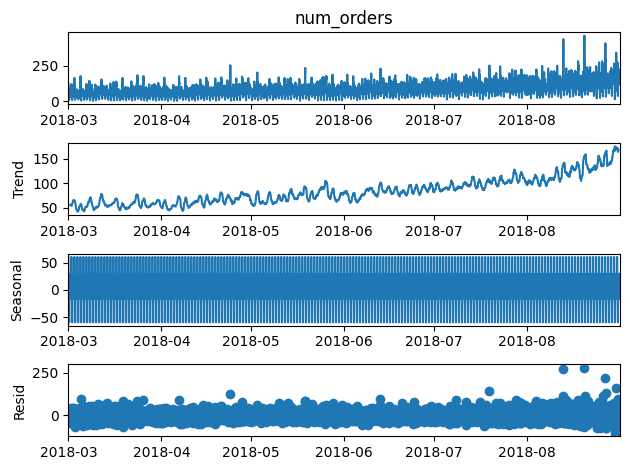

In [7]:
# check stationarity
result = adfuller(df['num_orders'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# check seasonality
result = seasonal_decompose(df['num_orders'])
result.plot()
plt.show()

### Statistically, our ADF score and p-value of less than .05 would suggest the data is stantionary.  However looking at the resulting chart of season decomposition, we see a growing variation is standard deviation along with a trend that increases as time goes on. 

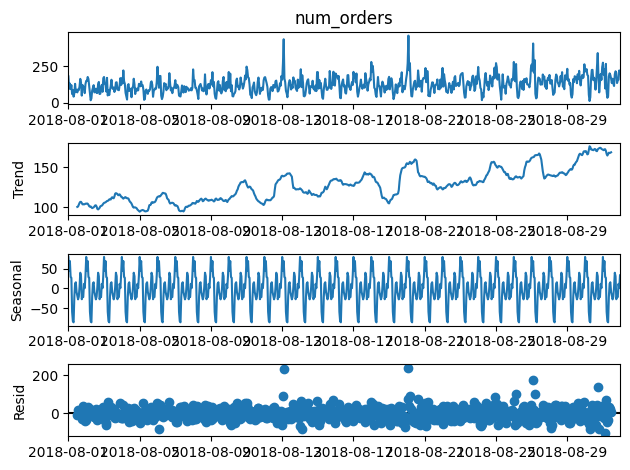

In [8]:
# Check seasonality month
aug_data = df.loc['2018-08-01':'2018-08-31']
result = seasonal_decompose(aug_data['num_orders'], model='additive')
result.plot()
plt.show()

### When resampling daily, we start to see a more predictable pattern in our trend and seasonality.

# Modeling 

RMSE Linear 55.579876257059084


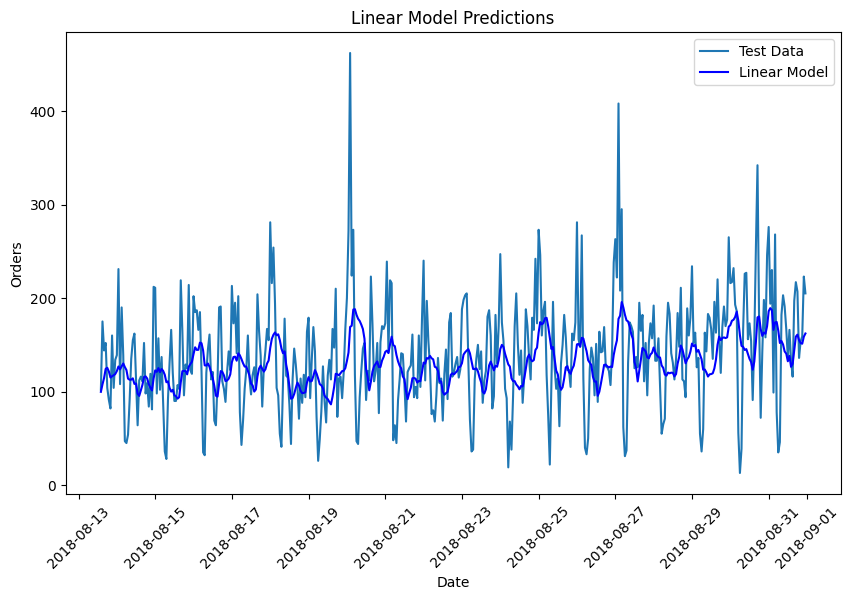

In [9]:
# train, test, split
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
# features and target
features = train.drop(columns=['num_orders'])
target = train['num_orders']
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

# make features function
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

make_features(df, 6, 10)
df.dropna(inplace=True)

# model
model = LinearRegression()
model.fit(features, target)
y_train_pred = model.predict(features)
mae_train = mean_absolute_error(target, y_train_pred)

# evaluate
y_test_pred = model.predict(features_test)
rmse_test = np.sqrt(mean_squared_error(target_test, y_test_pred))

print("RMSE Linear", rmse_test)

# plot
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['num_orders'], label='Test Data')
plt.plot(test.index, y_test_pred, label='Linear Model', color='blue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Orders') 
plt.title('Linear Model Predictions')
plt.legend()
plt.show()

### The linear model captures the trend in our test data well. However it does not account for the seasonal variation the best. 

RMSE for the training set: 22.28366673276394


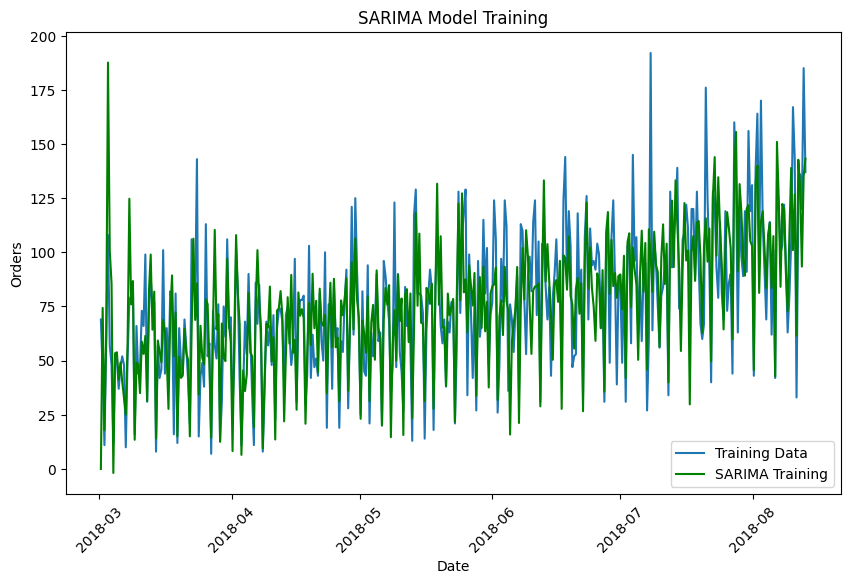

In [17]:
# features
make_features(df, 4, 4)
df.dropna(inplace=True)

# SARIMA model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)
best_sarima_model = SARIMAX(train['num_orders'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
best_sarima_model_fit = best_sarima_model.fit(disp=False)


train_pred = best_sarima_model_fit.predict(start=0, end=len(train)-1)
test_pred = best_sarima_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# evaluation
train_rmse = np.sqrt(mean_squared_error(train['num_orders'], train_pred))
test_rmse = np.sqrt(mean_squared_error(test['num_orders'], test_pred))
print("RMSE for the training set:", train_rmse)
#print("RMSE for the test set:", test_rmse)

# plot (every 10th value)
plt.figure(figsize=(10, 6))
plt.plot(train.index[::10], train['num_orders'][::10], label='Training Data')
plt.plot(train.index[::10], train_pred[::10], label='SARIMA Training', color='green')
#plt.plot(test.index[::10], test['num_orders'][::10], label='Test Data')
#plt.plot(test.index[::10], test_pred[::10], label='SARIMA Test', color='blue')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('SARIMA Model Training')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### We experimented with several models, and numerous methods to tune hyperparameters.  Often times finding we can achieve low RMSE values on our training data, only to return high values when we go to test.  These models were overfitting or lacked the ability to account for seasonal variance.  The SARIMA model gave us the most consistent performace overall.  

## Testing

RMSE for the test set: 44.530011826539805


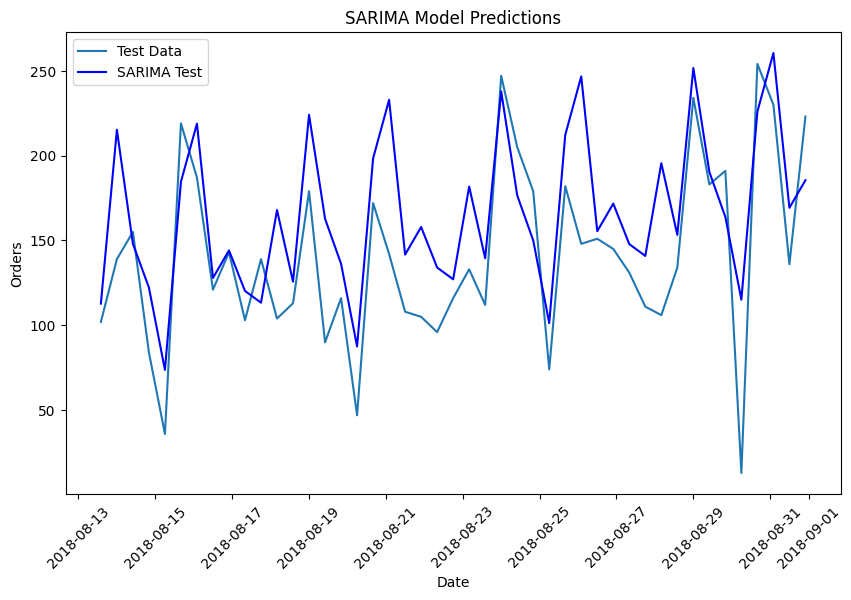

In [16]:
# RMSE test
print("RMSE for the test set:", test_rmse)

# plot (every 10th value)
plt.figure(figsize=(10, 6))
#plt.plot(train.index[::10], train['num_orders'][::10], label='Training Data')
#plt.plot(train.index[::10], train_pred[::10], label='SARIMA Training', color='green')
plt.plot(test.index[::10], test['num_orders'][::10], label='Test Data')
plt.plot(test.index[::10], test_pred[::10], label='SARIMA Test', color='blue')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('SARIMA Model Predictions')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### When we account for seasonality in our model, we improve our RMSE score from 55 to 44 using a SARIMA model. In charting the data, we see that our predictions doesn't perfectly capture the actual test results, but follows the same pattern and trend very closely. Giving us confidence in apply it in the future. 

### By taking historical taxi order data, we were able to resample the information to reflect hourly orders. We analyzed the data to account for any chronological trends or seasonal variances. Finally, we applied it to a model that is adaptive enough to predict hourly surges in taxi demands. This knowledge can easily be applied to meet changing customer needs and eliminate wasted time and effort for drivers at the Sweet Lift Taxi Company.